In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from scipy.ndimage import binary_erosion
import torch
from torchvision.transforms import functional as TF

import pietorch
# Examples to try: image, gif, brain??

# Poisson image editing examples
## Image (2D)

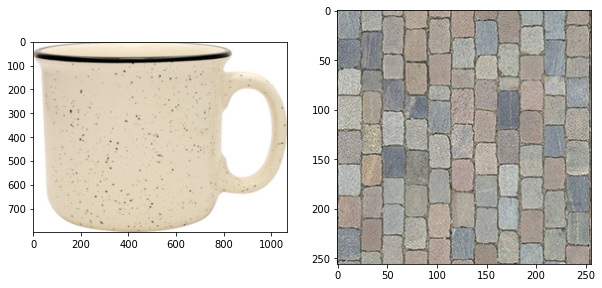

In [3]:
img_1_png = Image.open('example_images/mug.png')
img_1 = Image.new("RGB", img_1_png.size, (255, 255, 255))
img_1.paste(img_1_png, mask=img_1_png.getchannel('A'))

img_2 = Image.open('example_images/brick_texture.jpg')

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(img_1)
ax[1].imshow(img_2)

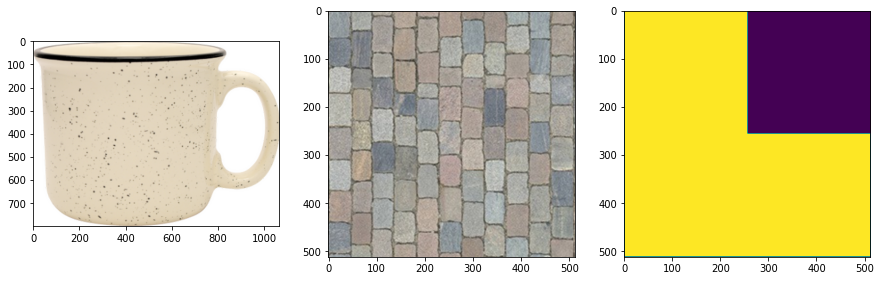

In [4]:
target = TF.to_tensor(img_1)

source = TF.resize(TF.to_tensor(img_2), [512, 512])

corner_coord = torch.tensor([144, 100])

mask = torch.zeros(source.shape[1:])
mask[1:-1, 1:-1] = 1
mask[:256, 256:512] = 0

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(torch.movedim(target, 0, -1))
ax[1].imshow(torch.movedim(source, 0, -1))
ax[2].imshow(mask)

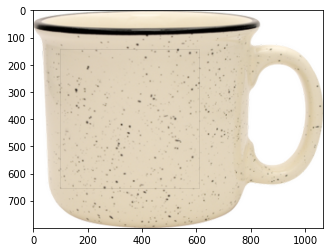

In [12]:
res = pietorch.blend(target, source, torch.zeros(source.shape[1:]), corner_coord, True, channels_dim=0)


plt.imshow(torch.movedim(res, 0, -1))

tensor(0.) - tensor(0.0013) / tensor(0.) - tensor(0.3693)
tensor(0.) - tensor(0.0012) / tensor(0.) - tensor(0.3468)
tensor(0.) - tensor(0.0011) / tensor(0.) - tensor(0.3045)


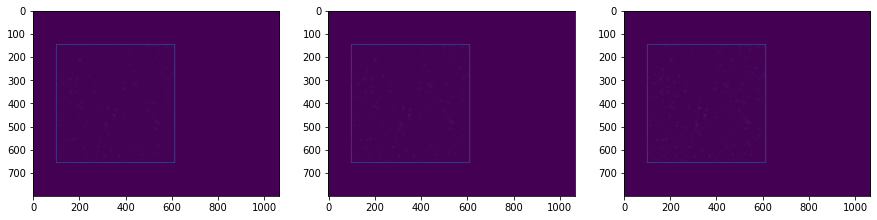

In [13]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
for i in range(target.shape[0]):

    diff = torch.abs(res[i] - target[i])
    print(torch.min(diff), '-', torch.mean(diff), '/', torch.median(diff), '-', torch.max(diff))
    ax[i].imshow(diff)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3141, 0.1724, 0.1839],
        [0.0000, 0.0000, 0.1796, 0.0090, 0.0040],
        [0.0000, 0.0000, 0.1896, 0.0036, 0.0019]])

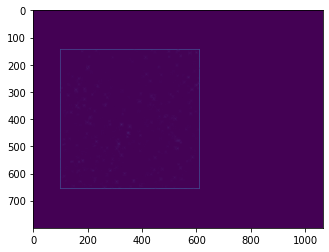

In [14]:
recon_diff = torch.abs(res - target).mean(0)

plt.imshow(recon_diff)

recon_diff[142:147, 98:103]

In [7]:
res[0, 141:147, 98:103]

tensor([[0.8353, 0.8314, 0.8275, 0.8235, 0.8235],
        [0.8353, 0.8314, 0.8275, 0.8196, 0.8157],
        [0.8353, 0.8314, 0.8275, 0.8196, 0.8157],
        [0.8353, 0.8353, 0.4900, 0.6389, 0.6230],
        [0.8392, 0.8392, 0.6443, 0.8450, 0.8361],
        [0.8353, 0.8392, 0.6332, 0.8438, 0.8417]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


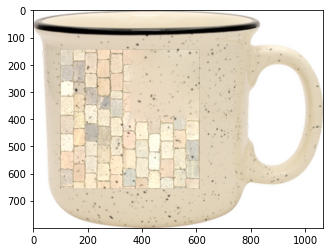

In [9]:
res = pietorch.blend(target, source, mask, corner_coord, True, channels_dim=0)


plt.imshow(torch.movedim(res, 0, -1))

tensor(0.4134)


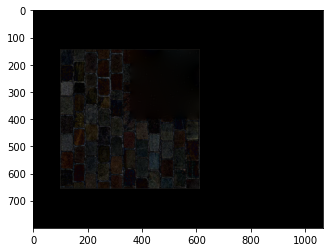

In [11]:
diff = torch.abs(res - target)
print(torch.max(diff))
plt.imshow(torch.movedim(diff, 0, -1))


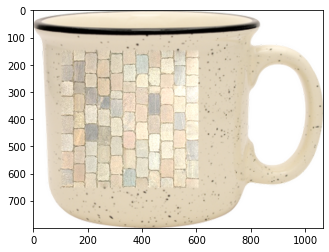

In [10]:
import cv2

cv_img_1 = np.array(img_1)
cv_img_2 = np.array(TF.resize(img_2, (512, 512)))
cv_mask = np.ones(cv_img_2.shape[:2], dtype=np.uint8) * 255

cv_res = cv2.seamlessClone(cv_img_2,
                           cv_img_1,
                           cv_mask,
                           (356, 400),
                           cv2.NORMAL_CLONE)

plt.imshow(cv_res)

212


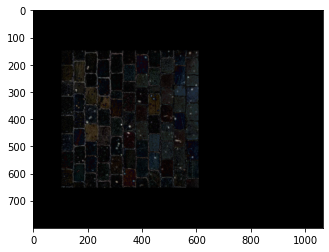

In [11]:
cv_diff = np.abs(cv_img_1.astype(int) - cv_res.astype(int))
print(np.max(cv_diff))

plt.imshow(cv_diff)

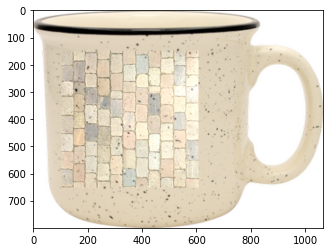

In [11]:
cv_img_1 = np.array(img_1)
cv_img_2 = np.array(TF.resize(img_2, (512, 512)))
cv_mask = np.ones(cv_img_2.shape[:2], dtype=np.uint8) * 255

cv_res = cv2.seamlessClone(cv_img_2,
                           cv_img_1,
                           cv_mask,
                           (356, 400),
                           cv2.MIXED_CLONE)

plt.imshow(cv_res)

111


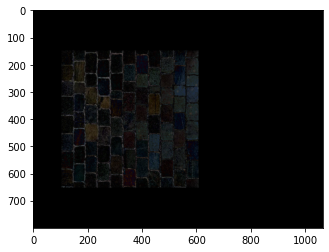

In [12]:
cv_diff = np.abs(cv_img_1.astype(int) - cv_res.astype(int))
print(np.max(cv_diff))

plt.imshow(cv_diff)

In [9]:
import imageio

def read_gif(file_path):
    return torch.stack([TF.to_tensor(im) for im in imageio.get_reader(file_path)])

wave = read_gif('example_images/wave.gif')[:, :3]
splat = read_gif('example_images/splat.gif')[:, :3]

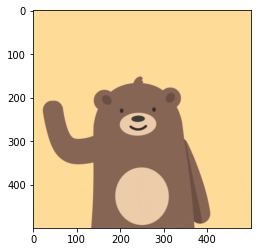

In [10]:
plt.imshow(torch.movedim(wave[0], 0, -1))

In [11]:
target_gif = wave

source_gif = torch.zeros_like(wave)
splat_both_ways = torch.cat([splat, torch.flip(splat, [0])])

source_gif[4:4 + splat_both_ways.shape[0], :, 100: 400, 100:400] = TF.resize(splat_both_ways, (300, 300))

mask_gif = torch.zeros((wave.shape[0], *wave.shape[2:]))
mask_gif[5:3 + splat_both_ways.shape[0], 101: 399, 101:399] = 1

In [12]:
res_gif = pietorch.blend(target_gif, source_gif, mask_gif, True, channels_dim=1)

In [13]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

gif = res_gif

anim_fig, anim_ax = plt.subplots()
img_ax = plt.imshow(torch.movedim(gif[0], 0, -1))

def animate_gif(frame_num):
    img_ax.set_data(torch.movedim(gif[frame_num], 0, -1))
    return img_ax

anim =  FuncAnimation(anim_fig, animate_gif, frames=len(gif), interval=15)
plt.show()


<IPython.core.display.Javascript object>

In [14]:
anim.save('example_images/blended.gif', fps=30)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i